In [7]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [8]:
import numpy as np
import pandas as pd

In [9]:
import datetime as dt

In [18]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [19]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [20]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [21]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [22]:
['measurement', 'station']

['measurement', 'station']

In [23]:
 # Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [24]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [25]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)
# Collect the names of tables within the measurement database
columns = inspector.get_columns('measurement')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


# Exploratory Climate Analysis

In [27]:
# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#calculate the year ago from the above date
year_ago = dt.date(2017,8,23) - dt.timedelta(days= 365)
print(year_ago)

2016-08-23


In [29]:
# Perform a query to retrieve the data and precipitation scores

Results = session.query(Measurement.date, Measurement.prcp).\
            filter(Measurement.date >= year_ago, Measurement.prcp!= None).\
            order_by(Measurement.date).all()

In [30]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date
hawaii_prcp = pd.DataFrame(Results, columns = ['date', 'precipitation']).dropna()
hawaii_prcp.set_index('date', inplace = True)
hawaii_prcp.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


In [31]:
hawaii_prcp.index

Index(['2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23', '2016-08-23',
       '2016-08-23', '2016-08-24', '2016-08-24', '2016-08-24', '2016-08-24',
       ...
       '2017-08-21', '2017-08-21', '2017-08-21', '2017-08-22', '2017-08-22',
       '2017-08-22', '2017-08-23', '2017-08-23', '2017-08-23', '2017-08-23'],
      dtype='object', name='date', length=2021)

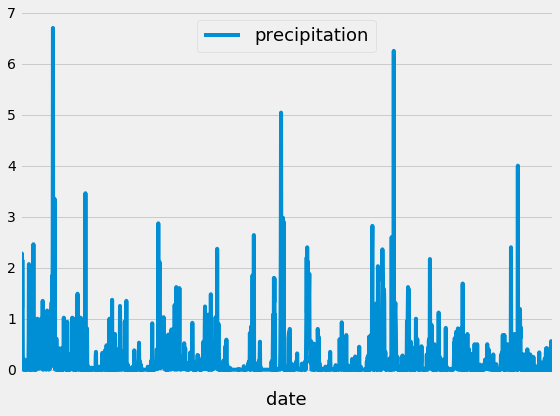

In [36]:
# Use Pandas Plotting with Matplotlib to plot the data
hawaii_prcp.plot(figsize=(8,6))

# labeling the plot
plt.legend(loc = 'upper center', fontsize = 18 )
plt.tight_layout()
plt.xlabel('date', fontsize = 18)
plt.xticks([])
plt.tight_layout()

plt.savefig('Images/Precipitation.png')

In [37]:
# Use Pandas to calcualte the summary statistics for the precipitation data
hawaii_prcp.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [38]:
# Design a query to show how many stations are available in this dataset?

session.query(Measurement.station).distinct().count()

9

In [40]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

active_stations_results = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

for row in active_stations_results:
    print(row)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [41]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
lowest_temp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs).first()
highest_temp = session.query(Measurement.tobs).\
              filter_by(station = 'USC00519281').\
              order_by(Measurement.tobs.desc()).first()
mean_temp = session.query(func.avg(Measurement.tobs)).\
             filter_by(station = 'USC00519281').all()
                          
print([lowest_temp[0], highest_temp[0], mean_temp[0][0]])

[54.0, 85.0, 71.66378066378067]


In [43]:
# Choose the station with the highest number of temperature observations.
busy_station = session.query(Measurement.station).\
           group_by(Measurement.station).\
           order_by(func.count(Measurement.tobs).desc()).first()[0]
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
year_temperature = session.query(Measurement.tobs).\
                    filter(Measurement.date >= year_ago, Measurement.station == "USC00519281").\
                    order_by(Measurement.tobs).all()

In [46]:
# Save the query results as a Pandas DataFrame

year_temperature_df = pd.DataFrame(year_temperature, columns=["Tobs"])
year_temperature_df.head()

,Tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


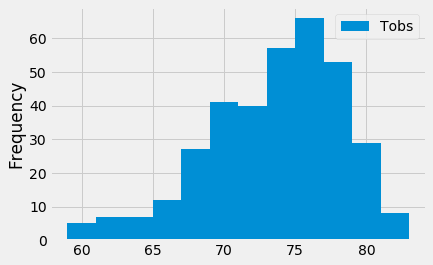

In [47]:
#Plot the results as a histogram with bins=12.
bins = 12
year_temperature_df.plot.hist(year_temperature, bins)
plt.savefig("Images/Station_Histogram.png")

In [48]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [49]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

prev_start_year = dt.date(2018,1,1) - dt.timedelta(days= 365)
# print(prev_start_year)
prev_end_year = prev_start_year + dt.timedelta(days= 5)
# print(prev_end_year)
temp = calc_temps(prev_start_year, prev_end_year)
print(temp)

[(62.0, 68.05714285714286, 74.0)]


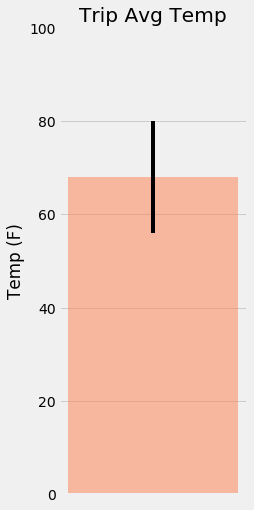

In [50]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_avg_temp = list(np.ravel(temp))
#trip_avg_temp 

tmin = trip_avg_temp[0]
tavg = trip_avg_temp[1]
tmax = trip_avg_temp[2]
peak_to_peak = tmax-tmin

plt.figure(figsize=(3,8))
plt.bar(1,tavg, color = 'coral',alpha = 0.5)
plt.errorbar(1,tavg, yerr=(peak_to_peak), color= 'black')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.savefig('Images/temperature.png')

In [51]:
columns = inspector.get_columns('station')
for column in columns:
    print(column['name'], column['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [52]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
results = session.query(func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation).\
          filter(Measurement.station == Station.station).\
          group_by(Measurement.station).\
          order_by(func.sum(Measurement.prcp).desc()).all()

Rainfall_station_sort = pd.DataFrame(results, columns = ['precipitation', 'station', 'name', 'latitude', 'longitude', 'elevation'])
Rainfall_station_sort

,precipitation,station,name,latitude,longitude,elevation
0,1068.09,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,588.64,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,382.62,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,295.68,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
4,234.49,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
5,131.62,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
6,92.68,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
7,70.87,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
8,43.44,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
